To achieve a given level of accuracy with the least resources, one must minimize the total number of floating-point operations. This total cost is the product of (cost per time step) times (number of time steps).

For scheme (1), the update for each of the $\sim N$ grid points scales as $O(N)$. The stability condition $\nu = \delta t / (\delta x)^2 \leq 0.5$ turns out to be the limiting factor. To refine the spacial grid (increase $N$), $\delta x = 1/N$ decreases, forcing the time step to decrease $\delta t \sim 1/N^2$. The total number of time steps therefore scales as $O(N^2)$. Hence, the total computational cost is $O(N^3)$.

For scheme (3), using Crank-Nicolson $\rho = 0.5$, the cost per time step requires solving a tridiagonal system of $\sim N$ equations. By using Thomas' algorithm, the cost scales as $O(N)$ but with a larger constant than that for scheme (1). Since the scheme is second-order accurate in both time and space, and the scheme is unconditionally stable, we can choose $\delta t$ to be proportional to $\delta x \sim 1/N$, ensuring accuracy and stability. The number of time steps scales as O(N). The total computational cost is $O(N^2)$.

Given a desired spatial accuracy, we first choose $N$ and then choose a large Courant number $\nu$, for example, $\nu \approx N$ corresponds to setting $\delta t\approx \delta x$.

Comparison of Numerical and Asymptotic Solutions at t = 10.0
------------------------------------------------------------
x          | Numerical θ     | Asymptotic θ    | Difference     
------------------------------------------------------------
0.00       | -90.00000000    | -90.00000000    | -0.00000000    
0.05       | -85.20890278    | -85.20888890    | -0.00001388    
0.10       | -80.46285338    | -80.46284532    | -0.00000805    
0.15       | -75.75941147    | -75.75939255    | -0.00001892    
0.20       | -71.09614800    | -71.09612988    | -0.00001812    
0.25       | -66.47064453    | -66.47062027    | -0.00002426    
0.30       | -61.88049262    | -61.88046903    | -0.00002359    
0.35       | -57.32329322    | -57.32326615    | -0.00002707    
0.40       | -52.79665600    | -52.79663018    | -0.00002582    
0.45       | -48.29819878    | -48.29817142    | -0.00002736    
0.50       | -43.82554687    | -43.82552145    | -0.00002543    
0.55       | -39.37633247    | -39.37

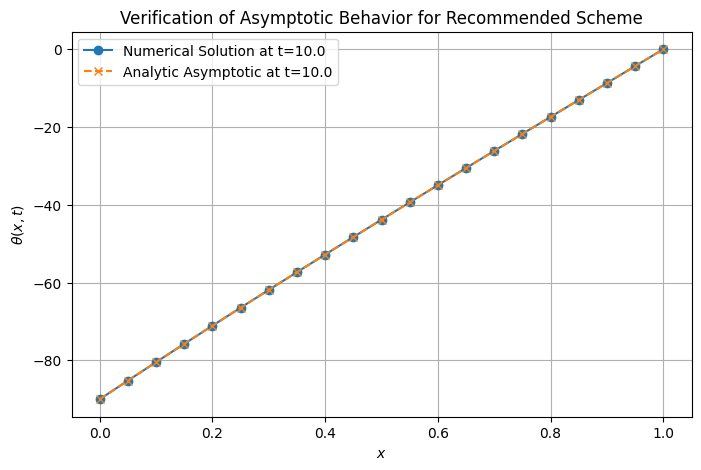

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded

def crank_nicolson(N, nu, t_target):
    '''
    Crank-Nicolson scheme.
    '''
    rho = 0.5
    dx = 1.0 / N
    dt = nu * dx**2
    num_steps = int(round(t_target / dt))
    theta = np.zeros(N + 1)
    N_internal = N - 1
    A_diag = (1 + 2 * rho * nu) * np.ones(N_internal)
    A_upper = -rho * nu * np.ones(N_internal - 1)
    A_lower = -rho * nu * np.ones(N_internal - 1)
    A_banded = np.vstack([np.append(0, A_upper), A_diag, np.append(A_lower, 0)])
    for m in range(num_steps):
        t_next = (m + 1) * dt
        b = (1 - rho) * nu * theta[:-2] + \
            (1 - 2 * (1 - rho) * nu) * theta[1:-1] + \
            (1 - rho) * nu * theta[2:]
        b[0] += rho * nu * f(t_next)
        theta_internal_next = solve_banded((1, 1), A_banded, b)
        theta[1:-1] = theta_internal_next
        theta[0] = f(t_next)
        theta[-1] = 0
    return theta

def f(t):
    '''
    Function f(t) = t(1-t).
    '''
    return t * (1 - t)

def alpha(x, num_terms=100):
    '''
    Computes alpha(x) from the Fourier series.
    '''
    pi = np.pi
    alpha_sum = sum(
        (4 / (n**3 * pi**3)) * np.sin(n*pi*x)
        for n in range(1, num_terms + 1)
        )
    return alpha_sum

def beta(x, num_terms=100):
    '''
    Computes beta(x) from the Fourier series.
    '''
    pi = np.pi
    beta_sum = sum(
        (-2 / (n**3 * pi**3) - 4 / (n**5 * pi**5)) * np.sin(n*pi*x)
        for n in range(1, num_terms + 1)
        )
    return beta_sum

def theta_asymptotic(x, t):
    '''
    Computes the asymptotic analytic solution for large t.
    '''
    return f(t) * (1 - x) + alpha(x) * t + beta(x)

# Parameters
N = 20
nu = 5.0  # Use a large nu.
t_large = 10.0

# Run the numerical simulation to the large time
x_grid = np.linspace(0, 1, N + 1)
theta_numerical_large_t = crank_nicolson(N, nu, t_large)

# Calculate the analytic asymptotic solution at the same time
theta_analytic_asym = np.array([theta_asymptotic(xi, t_large) for xi in x_grid])

# --- Tabulate and Plot Results ---
error = theta_numerical_large_t - theta_analytic_asym
print(f"Comparison of Numerical and Asymptotic Solutions at t = {t_large}")
print("-" * 60)
print(f"{'x':<10} | {'Numerical θ':<15} | {'Asymptotic θ':<15} | {'Difference':<15}")
print("-" * 60)
for i in range(len(x_grid)):
    print(f"{x_grid[i]:<10.2f} | "
          f"{theta_numerical_large_t[i]:<15.8f} | "
          f"{theta_analytic_asym[i]:<15.8f} | "
          f"{error[i]:<15.8f}")
print("-" * 60)

# --- Plotting ---
plt.figure(figsize=(8, 5))
plt.plot(x_grid, theta_numerical_large_t, 'o-', label=f'Numerical Solution at t={t_large}')
plt.plot(x_grid, theta_analytic_asym, 'x--', label=f'Analytic Asymptotic at t={t_large}')
plt.title('Verification of Asymptotic Behavior for Recommended Scheme')
plt.xlabel(f'$x$')
plt.ylabel(f'$\\theta(x, t)$')
plt.legend()
plt.grid(True)
plt.show()